# ICS2210 Assignment : Ben Taliana : 0124705L

### Importing Functions

In [49]:
import random
from collections import deque

##  Question 1: Construction of A

The snippet below constructs a class DFA and initializes it to be satisfy Questions **1a** , **1b** , **1c** and **1d**

In [50]:
class DFA:
    # Question 1a
    def __init__(self, min=16, max=64, debug=False, seed=None): # Min = 16 and Max = 64 
        self._rng = random.Random(seed)

        self.n = self._rng.randint(min, max) # Question 1a
        self.states = list(range(self.n)) # Question 1a

        # Question 1b
        self.accepting = {state: self._rng.choice([True, False]) for state in self.states} # Random accepting

        # Question 1c
        self.alphabet = ['a', 'b'] # a and b 
        # Random transitions for each state and symbol
        self.transition = {
            state: {
            symbol: self._rng.randint(0, self.n - 1)
            for symbol in self.alphabet
            } for state in self.states
        }

        # Question 1d
        self.start_state = self._rng.choice(self.states) # Random start state 

        # Helper function for debugging 
        if debug:   
            self.print_summary()

The <span style="color:lightblue">'print_summary'</span> function prints the attributes of a DFA for debugging

In [51]:
def print_summary(self):
    print(f"\n--- DFA Summary ---")
    print(f"Number of states: {self.n}") 
    print(f"Start state: {self.start_state}") 
    # Printing accepting states in order
    print("Accepting states:")
    for state in sorted(k for k, v in self.accepting.items() if v):
        print(f"  State {state}")
    
    # Printing transitions in order 
    print("Transitions:")
    for state in sorted(self.states):
        print(f"  State {state}: a -> {self.transition[state]['a']}, b -> {self.transition[state]['b']}")

# Adding the function to the DFA class
DFA.print_summary = print_summary

We can now instantiate A:

In [52]:
A = DFA(debug=True, seed=2025) 


--- DFA Summary ---
Number of states: 51
Start state: 22
Accepting states:
  State 0
  State 2
  State 3
  State 6
  State 7
  State 10
  State 11
  State 12
  State 13
  State 15
  State 17
  State 18
  State 19
  State 20
  State 21
  State 22
  State 23
  State 27
  State 28
  State 29
  State 30
  State 31
  State 32
  State 33
  State 34
  State 35
  State 37
  State 41
  State 46
  State 48
  State 50
Transitions:
  State 0: a -> 22, b -> 14
  State 1: a -> 34, b -> 33
  State 2: a -> 38, b -> 19
  State 3: a -> 10, b -> 17
  State 4: a -> 21, b -> 18
  State 5: a -> 23, b -> 4
  State 6: a -> 35, b -> 9
  State 7: a -> 42, b -> 17
  State 8: a -> 34, b -> 17
  State 9: a -> 36, b -> 40
  State 10: a -> 9, b -> 0
  State 11: a -> 22, b -> 46
  State 12: a -> 39, b -> 35
  State 13: a -> 37, b -> 34
  State 14: a -> 35, b -> 36
  State 15: a -> 9, b -> 32
  State 16: a -> 24, b -> 21
  State 17: a -> 32, b -> 15
  State 18: a -> 19, b -> 37
  State 19: a -> 1, b -> 32
  State 20:

## Question 2: Computing depth d<sub>A</sub> of A using BFS

The <span style="color:lightblue">'bfs_depth'</span> function calculates the depth d<sub>A</sub> of A

In [53]:
def bfs_depth(self):
    # Set all distances to inf for now (explanation in report)
    distances = {state: float('inf') for state in self.states}
    distances[self.start_state] = 0  # Set the start state's distance to 0

    # Using a double ended queue    
    queue = deque([self.start_state])
        
    while queue:
        current = queue.popleft()
        # Every transition from current state 
        for symbol in self.alphabet:
            next_state = self.transition[current][symbol]
            # If next isn't visited update distance and enqueue
            if distances[next_state] == float('inf'):
                distances[next_state] = distances[current] + 1
                queue.append(next_state)
        
    # Use only reachable states for depth
    reachable_distances = [d for d in distances.values() if d != float('inf')]

    return max(reachable_distances) if reachable_distances else 0 

DFA.bfs_depth = bfs_depth

We can now print the number of states in A and its depth d<sub>A</sub>:

In [54]:
print(f"Number of states in A: {A.n}")
d_A = A.bfs_depth()
print(f"Depth d_A of A: {d_A}")

Number of states in A: 51
Depth d_A of A: 11


## Question 3: Minimization of A using Hopcroft's Algorithm

### Pre-processing A for Minimization:

Before minimizing A, it needs to be **pruned** of **useless** and **unreachable** states, especially given the random nature of our DFA. The <span style="color:lightblue">'prune'</span> function fulfils this with helpers <span style="color:lightblue">'get_reachable_states'</span> and <span style="color:lightblue">'get_useful_states'</span>.

In [55]:
def prune(self):
    # Using helpers get_reachable_states and get_useful_states
    reachable = self.get_reachable_states()
    useful = self.get_useful_states()

    # Valid states are both reachable and useful 
    valid = reachable & useful

    # If valid states remain, reset to an empty DFA
    if not valid:
        self.states = []
        self.n = 0
        self.accepting = {}
        self.transition = {}
        self.start_state = None
        return

    
    state_mapping = {old: new for new, old in enumerate(valid)}

    # Creating a trap state for possible invalid transitions
    trap_state_id = len(state_mapping)

    # Update state list and count 
    self.states = list(state_mapping.values())
    self.n = len(self.states)

    # Remap accepting states
    self.accepting = {
        state_mapping[s]: self.accepting[s]
        for s in valid
    }

    # Remap transitions
    new_transitions = {}
    trap_needed = False # default 

    for s in valid:
        new_s = state_mapping[s]
        new_transitions[new_s] = {}
        for symbol in self.alphabet:
            t = self.transition[s][symbol]
            if t not in valid: # If transition is invalid, map to the trap 
                trap_needed = True
                new_transitions[new_s][symbol] = trap_state_id
            else:
                new_transitions[new_s][symbol] = state_mapping[t] # Else map to new state 

    # If needed, define the trap state
    if trap_needed:
        self.states.append(trap_state_id)
        self.n += 1
        self.accepting[trap_state_id] = False
        new_transitions[trap_state_id] = {'a': trap_state_id, 'b': trap_state_id}

    # Update transitions and start 
    self.transition = new_transitions
    self.start_state = state_mapping[self.start_state]

DFA.prune = prune

In [56]:
def get_reachable_states(self):
    visited = set([self.start_state]) # Starting with the start state being visited
    queue = deque([self.start_state]) # BFS double-ended queue
    
    # BFS to find all reachable states
    while queue:
        current = queue.popleft()
        for symbol in self.alphabet:
            next_state = self.transition[current][symbol]
            if next_state not in visited:
                visited.add(next_state)
                queue.append(next_state)
    return visited

# Add to DFA class
DFA.get_reachable_states = get_reachable_states

In [57]:
def get_useful_states(self):
    # Building a reverse graph where each state points to states that can transition to it
    reverse_graph = {s: [] for s in self.states}
    for state in self.states:
        for symbol in self.alphabet:
            next_state = self.transition[state][symbol]
            reverse_graph[next_state].append(state)

    # Start from all accepting states
    useful = set()
    stack = [s for s in self.states if self.accepting[s]]

    # Traverse backwards to find all states that can reach an accepting state
    while stack:
        s = stack.pop()
        if s not in useful:
            useful.add(s)
            stack.extend(reverse_graph[s])

    return useful

DFA.get_useful_states = get_useful_states

The <span style="color:lightblue">'hopcroft_minimization'</span> function below implements Hopcroft's Algorithm

In [58]:
def hopcroft_minimization(self):
    states = set(self.states)

    # Split states into accepting and non-accepting
    accepting_states = frozenset(state for state in states if self.accepting[state])
    non_accepting_states = frozenset(states - accepting_states)

    P = [] # Create the partition list
    if accepting_states:
        P.append(accepting_states)
    if non_accepting_states:
        P.append(non_accepting_states)

    # Create the worklist with the smaller partition
    W = set()
    if accepting_states and non_accepting_states:
        W.add(accepting_states if len(accepting_states) <= len(non_accepting_states) else non_accepting_states)
    elif accepting_states:
        W.add(accepting_states)
    elif non_accepting_states:
        W.add(non_accepting_states)

    # Precompute reverse transitions for each symbol for efficiency
    reverse_transition = {
        'a': {s: set() for s in states},
        'b': {s: set() for s in states}
    }
    for s in states:
        for symbol in self.alphabet:
            target = self.transition[s][symbol]
            reverse_transition[symbol][target].add(s)

    # Refinement loop
    while W:
        A = W.pop()
        for symbol in self.alphabet:
            X = set()
            for target in A:
                X.update(reverse_transition[symbol][target])
            X = frozenset(X)

            partition_changes = []
            for i, Y in enumerate(P):
                intersection = Y & X
                difference = Y - X
                if intersection and difference:
                    partition_changes.append((i, Y, intersection, difference))

            # Refine the partitions and update the worklist
            for i, Y, intersection, difference in reversed(partition_changes):
                P.pop(i)
                P.append(intersection)
                P.append(difference)

                if Y in W:
                    W.discard(Y)
                    W.add(intersection)
                    W.add(difference)
                else:
                    W.add(intersection if len(intersection) <= len(difference) else difference)

    # Mapping the old states to new states 
    state_to_new_state = {
        state: new_state
        for new_state, partition in enumerate(P)
        for state in partition
    }

    # Building the minimized DFA
    minimized_dfa = DFA.empty_dfa()
    minimized_dfa.n = len(P)
    minimized_dfa.states = list(range(len(P)))

    # Creating the accepting states in minimized DFA
    minimized_dfa.accepting = {
        new_state: any(self.accepting[state] for state in partition)
        for new_state, partition in enumerate(P)
    }

    # Creating  the transitions in minimized DFA
    minimized_dfa.transition = {
        new_state: {
            symbol: state_to_new_state[self.transition[next(iter(partition))][symbol]]
            for symbol in self.alphabet
        } for new_state, partition in enumerate(P)
    }

    # Set start state
    minimized_dfa.start_state = state_to_new_state[self.start_state]
    return minimized_dfa

# Adding to the DFA class
DFA.hopcroft_minimization = hopcroft_minimization


The <span style="color:lightblue">'empty_dfa'</span> function is a helper for the minimization function and creates an empty DFA for reconstruction:

In [59]:
@classmethod
def empty_dfa(cls):
    obj = cls(min=1, max=1)  # call to satisfy init
    obj.n = 0
    obj.states = []
    obj.accepting = {}
    obj.transition = {}
    obj.start_state = None
    return obj

DFA.empty_dfa = empty_dfa

Now we can prune A and minimize it to get M:

In [60]:
A.prune()
M = A.hopcroft_minimization() 

## Question 4: Computing the depth d<sub>M</sub> of M using BFS

In [61]:
print(f"Number of states in M: {M.n}")
d_M = M.bfs_depth()
print(f"Depth d_M of M: {d_M}")

Number of states in M: 38
Depth d_M of M: 11


## Question 5: Tarjan's Algorithm and SCCs

The <span style="color:lightblue">'compute_sccs'</span> function implements Tarjan's Algorithm for computing SCCs

In [62]:
def compute_sccs(self):
    index = 0  
    index_map = {}  # State indices
    lowlink_map = {}  # Dict for lowest index
    stack = []  # Stack for current path
    on_stack = set()  # Set for looking up states
    sccs = [] # List for SCCs

    # Recursive DFS function
    def strongconnect(v):
        nonlocal index # Allows modification of index from strongconnect
        index_map[v] = index
        lowlink_map[v] = index
        index += 1
        stack.append(v)
        on_stack.add(v)

        for symbol in self.alphabet:
            w = self.transition[v][symbol]
            if w not in index_map: # If w is not visited
                strongconnect(w) 
                lowlink_map[v] = min(lowlink_map[v], lowlink_map[w]) 
            elif w in on_stack:
                lowlink_map[v] = min(lowlink_map[v], index_map[w]) # Update lowlink

        if lowlink_map[v] == index_map[v]: # If v lowlink = index then v is a root node 
            scc = []
            while True:
                w = stack.pop()
                on_stack.remove(w)
                scc.append(w)
                if w == v: # If at the root
                    break
            sccs.append(scc)

    for state in self.states:
        # If state hasn't been visited
        if state not in index_map:
            strongconnect(state)

    return sccs

DFA.compute_sccs = compute_sccs

Now we can compute A and M's SCCs, their quantity, the smallest and the largest:

In [63]:
sccs_A = A.compute_sccs()
sizes_A = [len(scc) for scc in sccs_A]
print(f"Number of SCCs in A: {len(sccs_A)}")
print(f"Size of largest SCC in A: {max(sizes_A)}")
print(f"Size of smallest SCC in A: {min(sizes_A)}")

Number of SCCs in A: 1
Size of largest SCC in A: 39
Size of smallest SCC in A: 39


In [64]:
sccs_M = M.compute_sccs()
sizes_M = [len(scc) for scc in sccs_M]
print(f"Number of SCCs in M: {len(sccs_M)}")
print(f"Size of largest SCC in M: {max(sizes_M)}")
print(f"Size of smallest SCC in M: {min(sizes_M)}")

Number of SCCs in M: 1
Size of largest SCC in M: 38
Size of smallest SCC in M: 38


## Empirical Testing and Edge Cases

### Visualization Function using Graphviz

In [65]:
from graphviz import Digraph
from IPython.display import Image, display

The <span style="color:lightblue">'visualize_dfa'</span> is a function that allows for a graphical representation of DFAs

In [66]:
def visualize_dfa(dfa, title="DFA Visualization"):
    dot = Digraph(comment=title)
    dot.attr(rankdir='LR')

    # Add accepting and non-accepting states
    for state in dfa.states:
        shape = 'doublecircle' if dfa.accepting.get(state, False) else 'circle'
        dot.node(str(state), shape=shape)

    # Mark start state with a dummy arrow
    dot.node("start", shape="point")
    dot.edge("start", str(dfa.start_state), label="start")

    # Add transitions
    for state in dfa.states:
        for symbol in dfa.alphabet:
            target = dfa.transition[state][symbol]
            dot.edge(str(state), str(target), label=symbol)

    return dot

### Minimization Testing and Edge Cases:

The <span style="color:lightblue">'accepts_string'</span> function checks whether our DFA accepts or rejects the given string.

In [67]:
def accepts_string(self, input_string):
    # Start state 
    state = self.start_state
    # Process every symbol in the string
    for symbol in input_string:
        # If the symbol is not in the alphabet
        if symbol not in self.transition[state]:
            return False # Reject 
        # Next state 
        state = self.transition[state][symbol]
    # Check if its accepting 
    return self.accepting.get(state, False)

DFA.accepts_string = accepts_string

The functions <span style="color:lightblue">'generate_random_strings'</span> and <span style="color:lightblue">'validate_equivalence'</span> use the <span style="color:lightblue">'accepts_string'</span> function to ensure that A and M are functionally equivalent, and that minimization preserves the language.

In [99]:
class DFATest:
    @staticmethod
    def generate_random_strings(count=10, max_length=10):
        # Generate a list of random strings
        strings = []
        for _ in range(count):
            length = random.randint(1, max_length)  # Random length
            s = ''.join(random.choice(['a', 'b']) for _ in range(length))  # Random string
            strings.append(s)
        return strings

    @staticmethod
    def validate_equivalence(dfa, minimized_dfa, num_tests=15, max_len=10):
        print("\n--- Testing if A and M are functionally equivalent ---")
        test_strings = DFATest.generate_random_strings(num_tests, max_len)

        # Add empty string for edge case
        test_strings.append("")

        # Addding strings that are the same length as the DFA depth 
        if hasattr(dfa, 'bfs_depth'):
            try:
                depth_a = dfa.bfs_depth()
            except Exception:
                depth_a = max_len
        else:
            depth_a = max_len
        if hasattr(minimized_dfa, 'bfs_depth'):
            try:
                depth_m = minimized_dfa.bfs_depth()
            except Exception:
                depth_m = max_len
        else:
            depth_m = max_len

        # Generate strings at DFA depth
        test_strings.append('a' * depth_a)
        test_strings.append('b' * depth_a)
        test_strings.append('ab' * (depth_a // 2))
        test_strings.append('ba' * (depth_a // 2))
        test_strings.append('a' * depth_m)
        test_strings.append('b' * depth_m)
        test_strings.append('ab' * (depth_m // 2))
        test_strings.append('ba' * (depth_m // 2))

        # Add some repetitive pattern strings
        test_strings.append('ababababab')
        test_strings.append('aaaaaaaaaa')
        test_strings.append('bbbbbbbbbb')
        test_strings.append('aabbaabbaabb')
        test_strings.append('bbaabbaabb')

        # Remove duplicates
        test_strings = list(set(test_strings))
        all_match = True
        mismatched_strings = []

        # Test each string on both DFAs
        for s in test_strings:
            result_a = dfa.accepts_string(s)
            result_m = minimized_dfa.accepts_string(s)
            print(f"Input: '{s}' -> A: {result_a}, M: {result_m}")
            if result_a != result_m:
                print("Mismatch found!")
                all_match = False
                mismatched_strings.append(s)

        if all_match:
            print("Test Passed: L(A) = L(M), all strings were accepted or rejected identically.")
        else:
            print("A functional mismatch was found between A and M.")
            print(f"Mismatched strings: {mismatched_strings}")
        
        # Assert for automated testing
        assert all_match, f"DFAs are not equivalent. Mismatched strings: {mismatched_strings}"
        
        return all_match

In [98]:
DFATest.validate_equivalence(A, M)


--- Testing if A and M are functionally equivalent ---
Input: '' -> A: True, M: True
Input: 'bab' -> A: False, M: False
Input: 'bbbbbbbbbbb' -> A: True, M: True
Input: 'aabababaaa' -> A: True, M: True
Input: 'aabbaabbaabb' -> A: False, M: False
Input: 'abbbaab' -> A: True, M: True
Input: 'bbaabbaabb' -> A: True, M: True
Input: 'bababababa' -> A: True, M: True
Input: 'b' -> A: True, M: True
Input: 'baa' -> A: True, M: True
Input: 'aaaaaaaaaa' -> A: True, M: True
Input: 'bbbbbbbaa' -> A: True, M: True
Input: 'aab' -> A: False, M: False
Input: 'ababababab' -> A: True, M: True
Input: 'a' -> A: True, M: True
Input: 'aaabb' -> A: True, M: True
Input: 'bbbbbbbbbb' -> A: False, M: False
Input: 'bbababb' -> A: True, M: True
Input: 'aaaaaaaaaaa' -> A: True, M: True
Test Passed: L(A) = L(M), all strings were accepted or rejected identically.


True

Now we can test our minimization algorithm by ensuring it passes through some credible examples:

In [70]:
@staticmethod
def example_1():

    dfa = DFA.empty_dfa()
    dfa.states = [0,1,2,3]
    dfa.n = 4
    dfa.accepting = {0: False, 1: True, 2: False, 3: False}

    # Starting from 0 for clarity
    dfa.transition = {
        0: {'a': 1, 'b': 3}, # State S or State 1
        1: {'a': 3, 'b': 2}, # State A or State 2
        2: {'a': 1, 'b': 3}, # State B or State 3
        3: {'a': 3, 'b': 3}, # State D or State 4
        }
    
    dfa.start_state = 0

    print("\n--- Example 1 ---")

    print_summary(dfa)

    # Visualize Example 1 before minimization
    dot_example = visualize_dfa(dfa, title="DFA Example 1 Before Minimization")
    dot_example.render('example_1', format='png', cleanup=True)
    display(Image('example_1.png'))

    # Prune and Minimize the DFA
    dfa.prune()
    minimized_dfa = dfa.hopcroft_minimization()

    print("\n--- Example 1 After Pruning and Minimization ---")

    print_summary(minimized_dfa)
    # Visualize Example 1 after minimization
    dot_example_minimized = visualize_dfa(minimized_dfa, title="DFA Example 1 After Minimization")
    dot_example_minimized.render('example_1_minimized', format='png', cleanup=True)
    display(Image('example_1_minimized.png'))

    # Checking for equivalence
    DFATest.validate_equivalence(dfa, minimized_dfa)


DFATest.example_1 = example_1


--- Example 1 ---

--- DFA Summary ---
Number of states: 4
Start state: 0
Accepting states:
  State 1
Transitions:
  State 0: a -> 1, b -> 3
  State 1: a -> 3, b -> 2
  State 2: a -> 1, b -> 3
  State 3: a -> 3, b -> 3


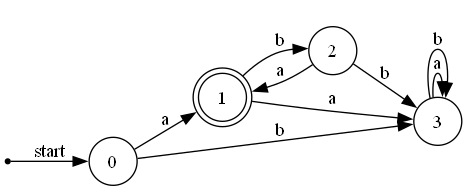


--- Example 1 After Pruning and Minimization ---

--- DFA Summary ---
Number of states: 3
Start state: 1
Accepting states:
  State 0
Transitions:
  State 0: a -> 2, b -> 1
  State 1: a -> 0, b -> 2
  State 2: a -> 2, b -> 2


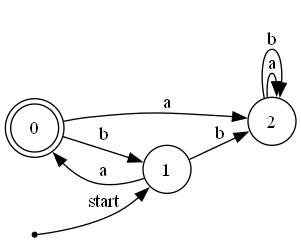


--- Testing if A and M are functionally equivalent ---
Input: '' -> A: False, M: False
Input: 'bb' -> A: False, M: False
Input: 'aaab' -> A: False, M: False
Input: 'ababababab' -> A: False, M: False
Input: 'ab' -> A: False, M: False
Input: 'ba' -> A: False, M: False
Input: 'bbaa' -> A: False, M: False
Input: 'b' -> A: False, M: False
Input: 'aa' -> A: False, M: False
Input: 'a' -> A: True, M: True
Input: 'aabaababa' -> A: False, M: False
Input: 'aaaaaaaaaa' -> A: False, M: False
Input: 'bbbbbbbbbb' -> A: False, M: False
Input: 'aabbaabbaabb' -> A: False, M: False
Input: 'bbaabbaabb' -> A: False, M: False
Test Passed: L(A) = L(M), all strings were accepted or rejected identically.


In [71]:
DFATest.example_1()

In [ ]:
@staticmethod
def example_2():
    # For this example let a = 0 and b = 1
    dfa = DFA.empty_dfa()
    dfa.states = [0,1,2,3,4,5]
    dfa.n = 4
    dfa.accepting = {0: False, 1: True, 2: True, 3: False, 4: True, 5: False}

    # Starting from 0 for clarity
    dfa.transition = {
        0: {'a': 3, 'b': 1}, # State q0 
        1: {'a': 2, 'b': 5}, # State q1
        2: {'a': 2, 'b': 5}, # State q2 
        3: {'a': 0, 'b': 4}, # State q3
        4: {'a': 2, 'b': 5}, # State q4
        5: {'a': 5, 'b': 5}, # State q5
        }
    
    dfa.start_state = 0

    print("\n--- Example 2 ---")

    print_summary(dfa)

    # Visualize Example 1 before minimization
    dot_example = visualize_dfa(dfa, title="DFA Example 2 Before Minimization")
    dot_example.render('example_2', format='png', cleanup=True)
    display(Image('example_2.png'))

    # Prune and Minimize the DFA
    dfa.prune()
    minimized_dfa = dfa.hopcroft_minimization()

    print("\n--- Example 2 After Pruning and Minimization ---")

    print_summary(minimized_dfa)
    # Visualize Example 1 after minimization
    dot_example_minimized = visualize_dfa(minimized_dfa, title="DFA Example 2 After Minimization")
    dot_example_minimized.render('example_2_minimized', format='png', cleanup=True)
    display(Image('example_2_minimized.png'))

    # Checking for equivalence
    DFATest.validate_equivalence(dfa, minimized_dfa)


DFATest.example_2 = example_2


--- Example 2 ---

--- DFA Summary ---
Number of states: 4
Start state: 0
Accepting states:
  State 1
  State 2
  State 4
Transitions:
  State 0: a -> 3, b -> 1
  State 1: a -> 2, b -> 5
  State 2: a -> 2, b -> 5
  State 3: a -> 0, b -> 4
  State 4: a -> 2, b -> 5
  State 5: a -> 5, b -> 5


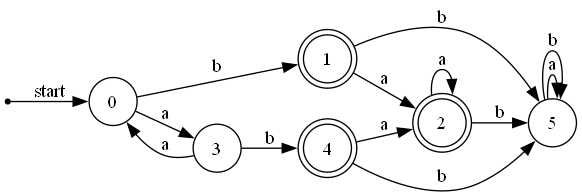


--- Example 2 After Pruning and Minimization ---

--- DFA Summary ---
Number of states: 3
Start state: 1
Accepting states:
  State 0
Transitions:
  State 0: a -> 0, b -> 2
  State 1: a -> 1, b -> 0
  State 2: a -> 2, b -> 2


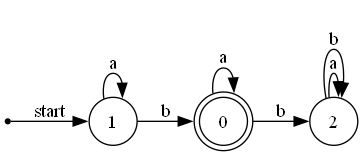


--- Testing if A and M are functionally equivalent ---
Input: '' -> A: False, M: False
Input: 'bb' -> A: False, M: False
Input: 'ababababab' -> A: False, M: False
Input: 'ab' -> A: True, M: True
Input: 'ba' -> A: True, M: True
Input: 'bbb' -> A: False, M: False
Input: 'aa' -> A: False, M: False
Input: 'baaabbaba' -> A: False, M: False
Input: 'aabbb' -> A: False, M: False
Input: 'aaaaaaaaaa' -> A: False, M: False
Input: 'bbbbbbbbbb' -> A: False, M: False
Input: 'aabbaabbaabb' -> A: False, M: False
Input: 'bbaabbaabb' -> A: False, M: False
Test Passed: L(A) = L(M), all strings were accepted or rejected identically.


In [73]:
DFATest.example_2()

In [74]:
@staticmethod
def example_3():
    print("\n--- Example 3 ---")

    # Visualize Example 3 before minimization
    dot_example = visualize_dfa(A, title="DFA Example 3 Before Minimization")
    dot_example.render('dfa_example_3', format='png', cleanup=True)
    display(Image('dfa_example_3.png'))

    print("\n--- Example 3 After Pruning and Minimization ---")

    print_summary(M)
    # Visualize Example 3 after minimization
    dot_example_minimized = visualize_dfa(M, title="DFA Example 3 After Minimization")
    dot_example_minimized.render('example_3_minimized', format='png', cleanup=True)
    display(Image('example_3_minimized.png'))

    # Checking for equivalence
    DFATest.validate_equivalence(A, M)


DFATest.example_3 = example_3


--- Example 3 ---


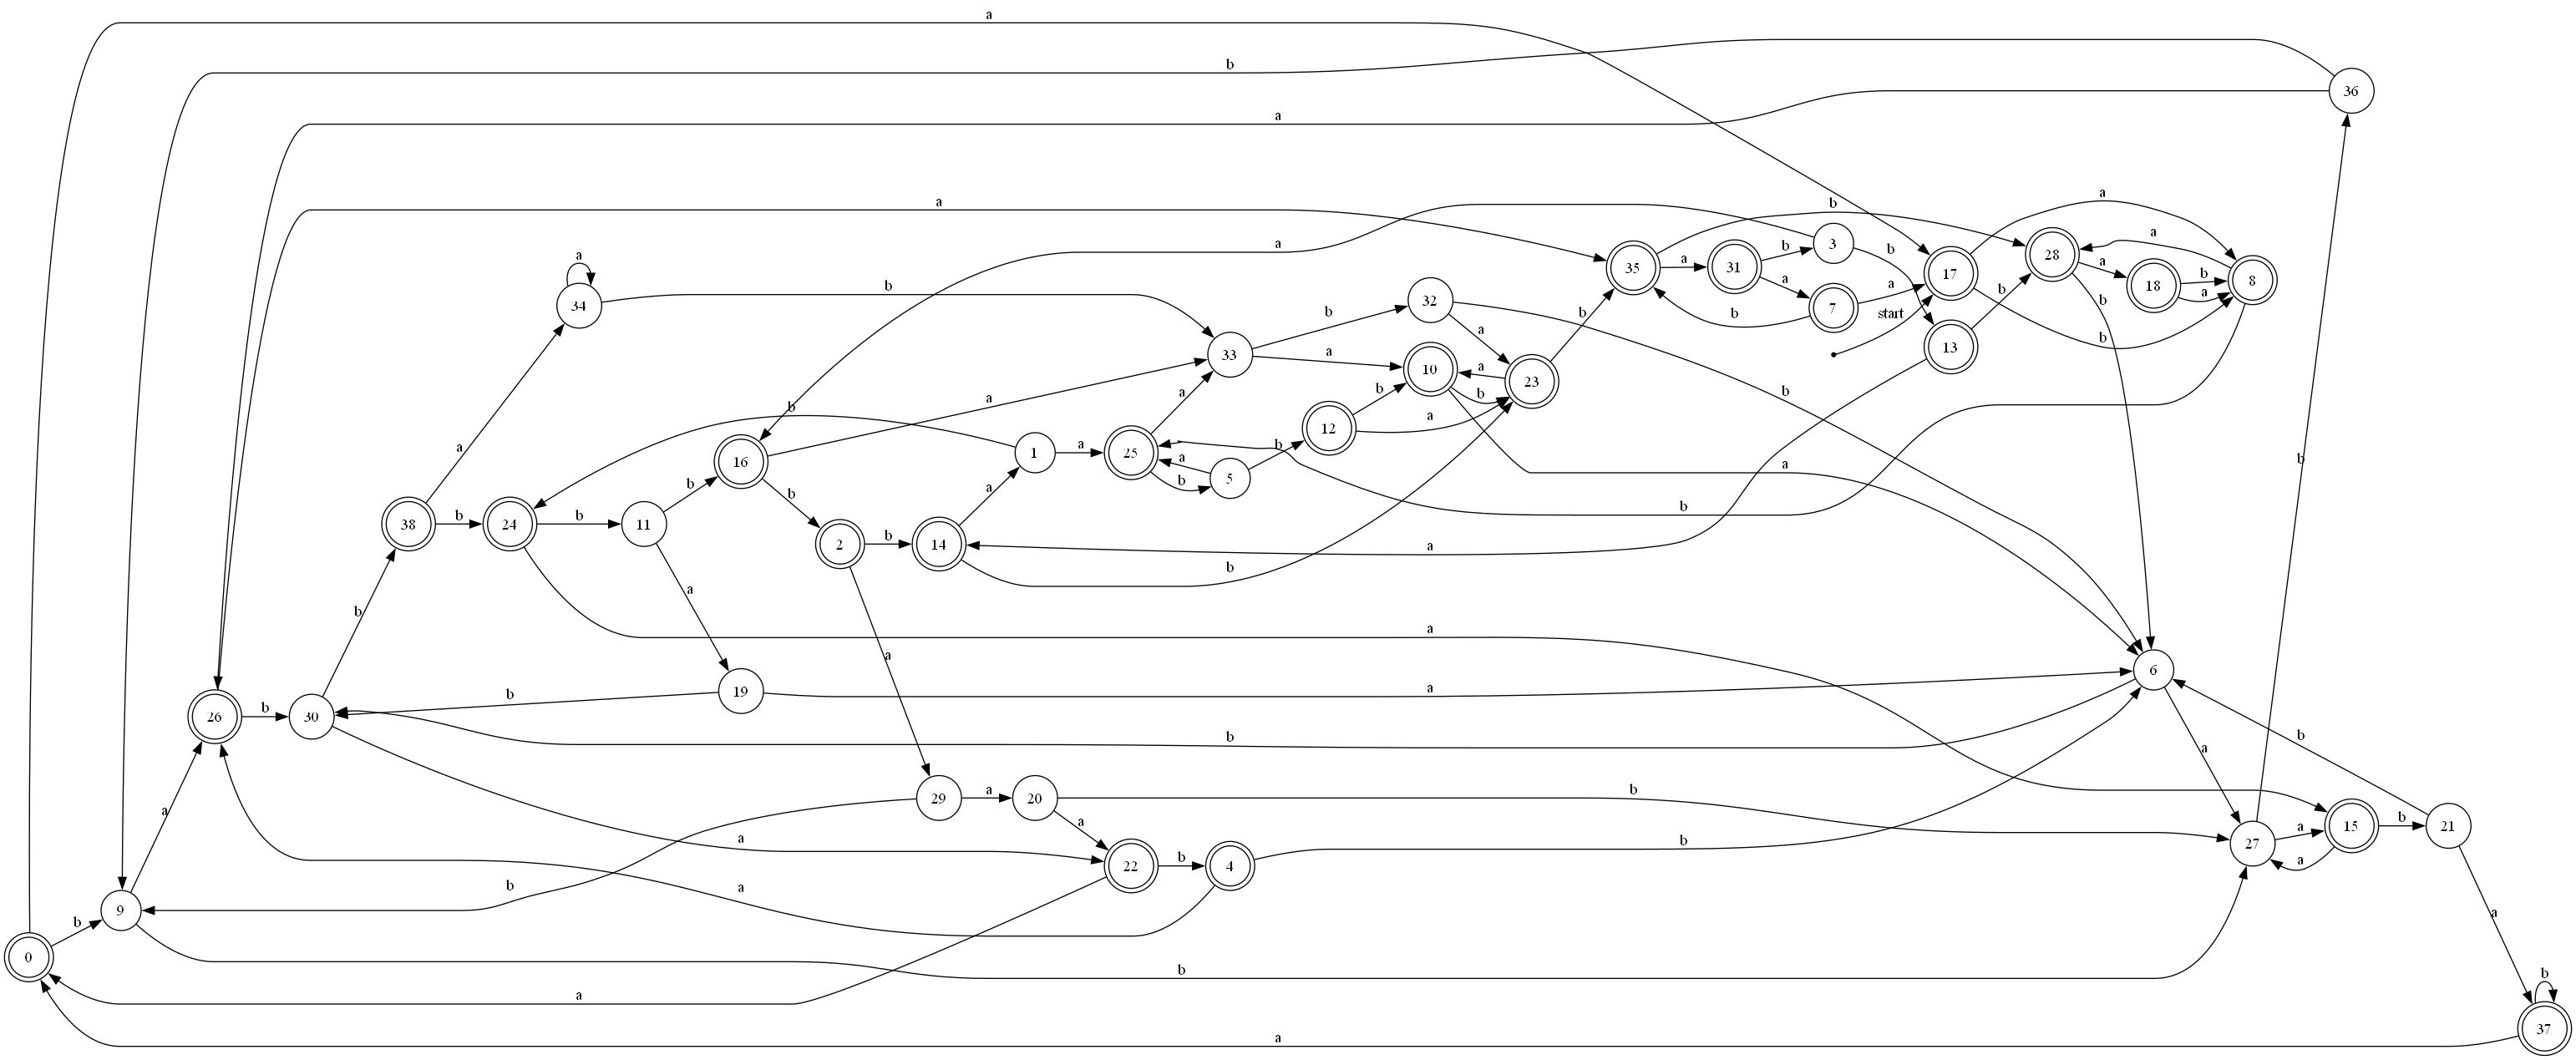


--- Example 3 After Pruning and Minimization ---

--- DFA Summary ---
Number of states: 38
Start state: 28
Accepting states:
  State 2
  State 3
  State 7
  State 8
  State 9
  State 11
  State 12
  State 15
  State 16
  State 17
  State 24
  State 25
  State 26
  State 27
  State 28
  State 29
  State 30
  State 31
  State 32
  State 33
  State 36
  State 37
Transitions:
  State 0: a -> 18, b -> 8
  State 1: a -> 11, b -> 14
  State 2: a -> 11, b -> 0
  State 3: a -> 33, b -> 12
  State 4: a -> 24, b -> 22
  State 5: a -> 8, b -> 26
  State 6: a -> 36, b -> 25
  State 7: a -> 27, b -> 24
  State 8: a -> 4, b -> 9
  State 9: a -> 13, b -> 16
  State 10: a -> 1, b -> 6
  State 11: a -> 1, b -> 23
  State 12: a -> 4, b -> 20
  State 13: a -> 35, b -> 34
  State 14: a -> 17, b -> 34
  State 15: a -> 28, b -> 34
  State 16: a -> 21, b -> 27
  State 17: a -> 30, b -> 6
  State 18: a -> 10, b -> 6
  State 19: a -> 19, b -> 4
  State 20: a -> 12, b -> 7
  State 21: a -> 12, b -> 2
  State 22

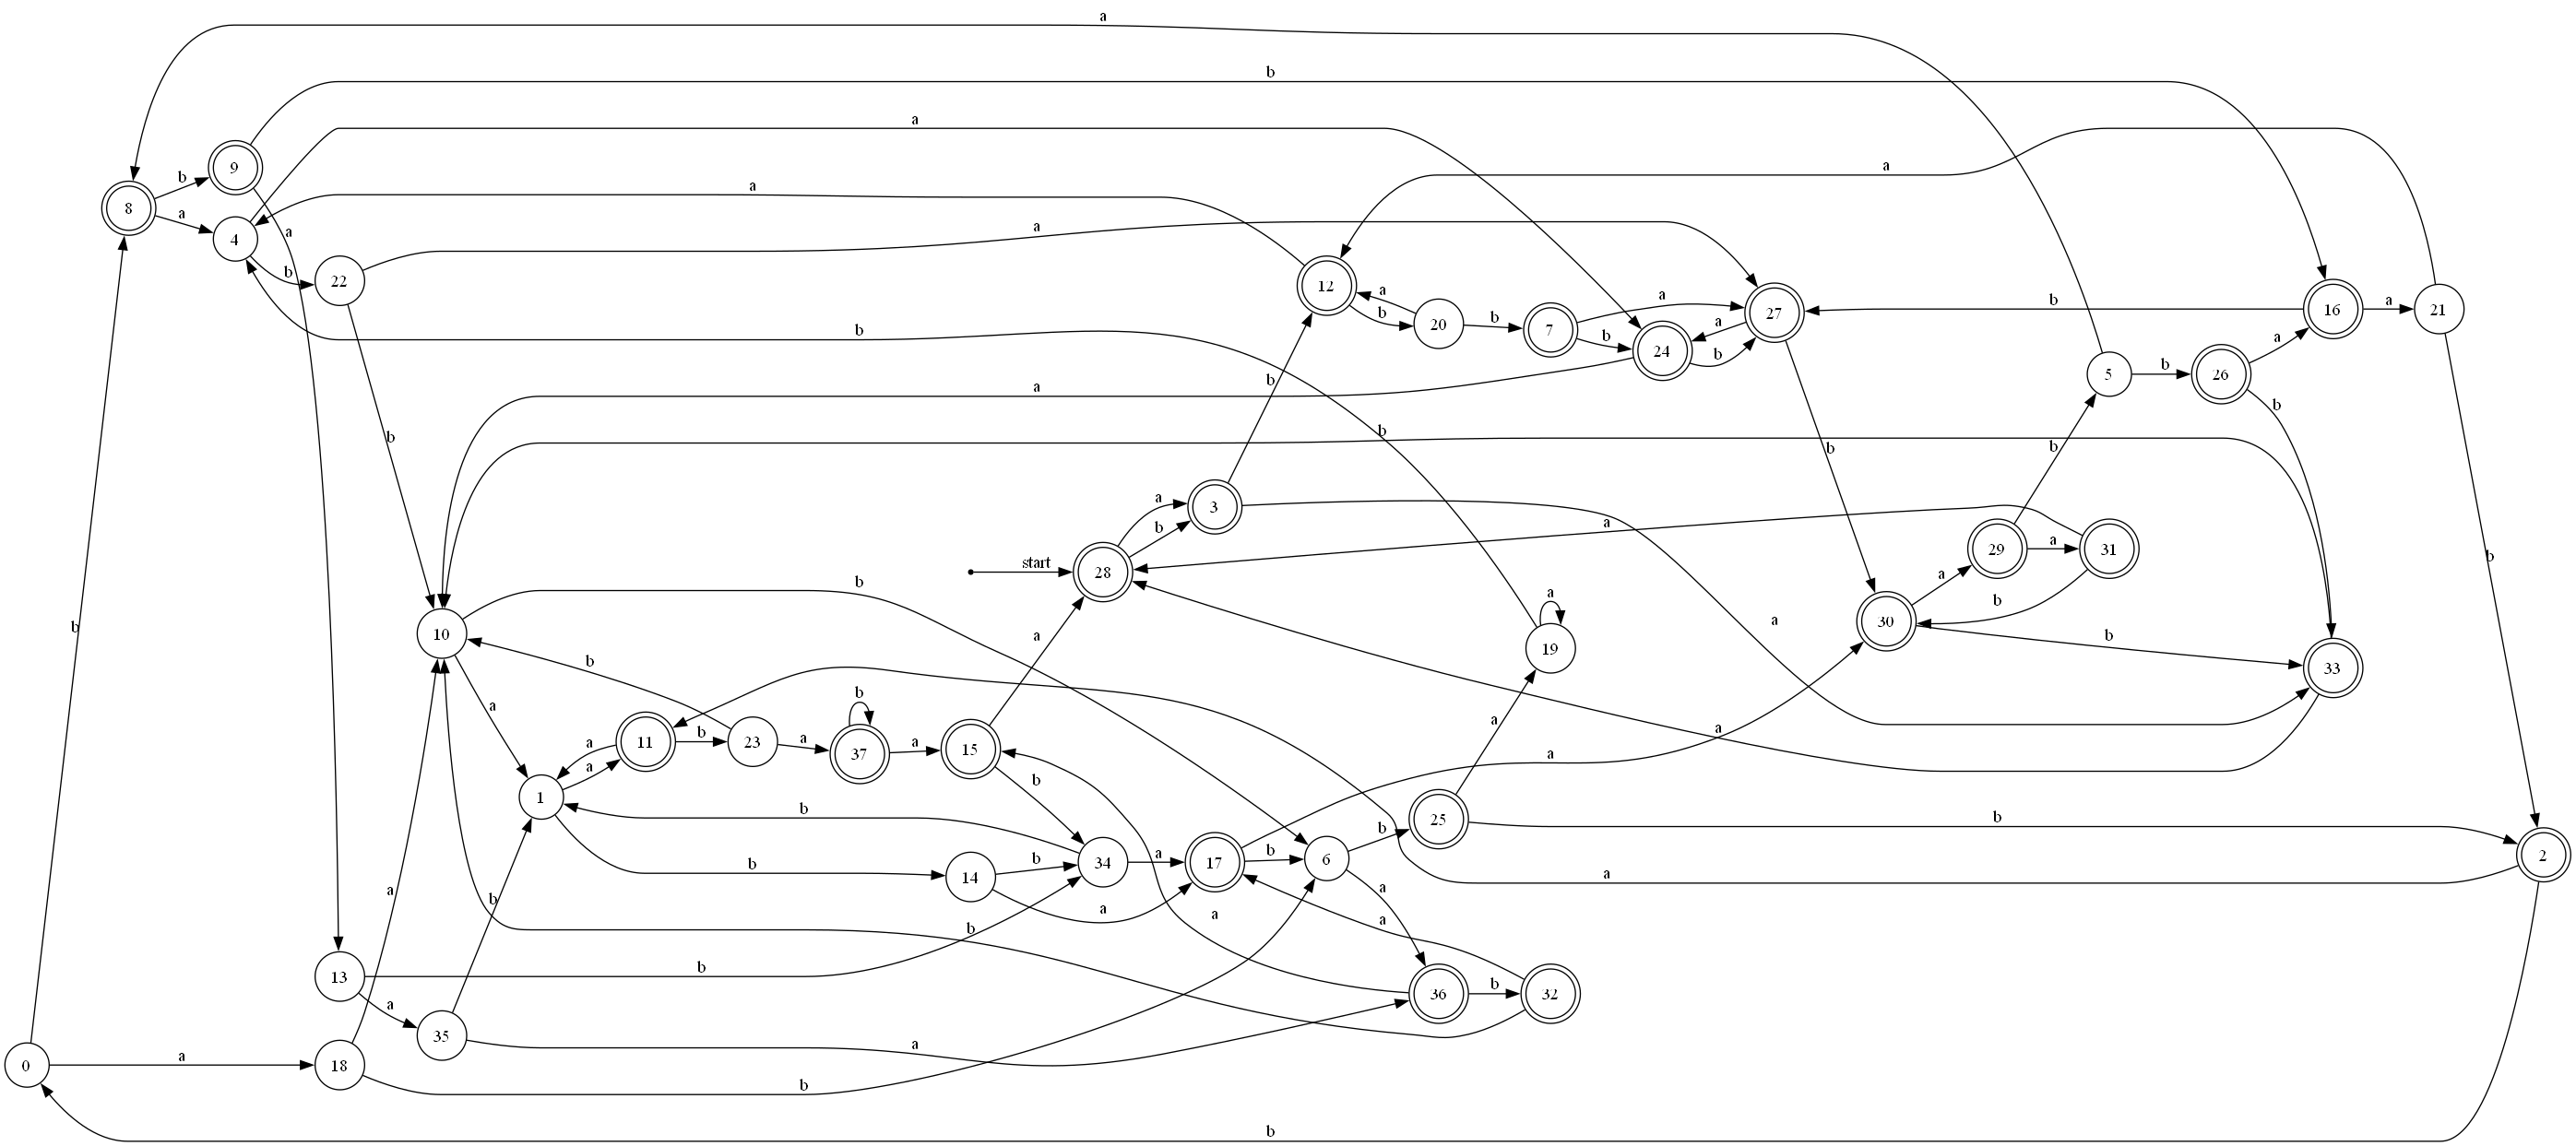


--- Testing if A and M are functionally equivalent ---
Input: '' -> A: True, M: True
Input: 'baaabaaa' -> A: False, M: False
Input: 'aaab' -> A: True, M: True
Input: 'bbbbbbbbbbb' -> A: True, M: True
Input: 'ababababab' -> A: True, M: True
Input: 'bababababa' -> A: True, M: True
Input: 'b' -> A: True, M: True
Input: 'baa' -> A: True, M: True
Input: 'aaaaaaaaaa' -> A: True, M: True
Input: 'bbbbbbbbbb' -> A: False, M: False
Input: 'aabbaabbaabb' -> A: False, M: False
Input: 'bbaabbaabb' -> A: True, M: True
Input: 'bbbabbba' -> A: False, M: False
Input: 'aaaaaaaaaaa' -> A: True, M: True
Test Passed: L(A) = L(M), all strings were accepted or rejected identically.


In [75]:
DFATest.example_3()

Now we can test some test cases to ensure our implementation can handle all types of DFAs

In [76]:
@staticmethod
def hopcroft_test_cases():
    print("--- Hopcroft Test Cases ---")

    # All-accepting DFA
    print("Test Case 1: All-Accepting DFA")
    dfa = DFA()
    dfa.n = 3
    dfa.states = [0, 1, 2]
    dfa.accepting = {0: True, 1: True, 2: True}
    dfa.transition = {
        0: {'a': 1, 'b': 2},
        1: {'a': 0, 'b': 2},
        2: {'a': 2, 'b': 1}
    }
    dfa.start_state = 0
    minimized = dfa.hopcroft_minimization()
    expected_states = 1
    print(f"Expected: {expected_states} state, Actual: {minimized.n} state")
    assert minimized.n == expected_states, "All-accepting DFA should minimize to 1 state"

    # Already minimal DFA
    print("Test Case 2: Already Minimal DFA")
    dfa = DFA()
    dfa.n = 2
    dfa.states = [0, 1]
    dfa.accepting = {0: False, 1: True}
    dfa.transition = {
        0: {'a': 1, 'b': 0},
        1: {'a': 1, 'b': 1}
    }
    dfa.start_state = 0
    minimized = dfa.hopcroft_minimization()
    expected_states = 2
    print(f"Expected: {expected_states} states, Actual: {minimized.n} states")
    assert minimized.n == expected_states, "Minimal DFA should remain unchanged"

    # One-State DFA
    print("Test Case 3: One-State DFA")
    dfa = DFA()
    dfa.n = 1
    dfa.states = [0]
    dfa.accepting = {0: True}
    dfa.transition = {
        0: {'a': 0, 'b': 0}
    }
    dfa.start_state = 0
    minimized = dfa.hopcroft_minimization()
    expected_states = 1
    expected_depth = 0  # Start is accepting, no depth needed
    print(f"Expected: {expected_states} states, Actual: {minimized.n} states")
    print(f"Expected Depth: {expected_depth}, Actual Depth: {dfa.bfs_depth()}")
    assert minimized.n == expected_states, "One-state DFA should remain as one state"
    assert dfa.bfs_depth() == expected_depth, "Depth of one-state DFA should be 0"

DFATest.hopcroft_test_cases = hopcroft_test_cases


In [77]:
DFATest.hopcroft_test_cases()

--- Hopcroft Test Cases ---
Test Case 1: All-Accepting DFA
Expected: 1 state, Actual: 1 state
Test Case 2: Already Minimal DFA
Expected: 2 states, Actual: 2 states
Test Case 3: One-State DFA
Expected: 1 states, Actual: 1 states
Expected Depth: 0, Actual Depth: 0


### Tarjan's Algorithm and SCCs Test Cases:

Similarly to the <span style="color:lightblue">'visualize_dfa'</span> function , the <span style="color:lightblue">'visualize_dfa_scc'</span> function visualizes DFAs but highlights the SCCs, the helper <span style="color:lightblue">'random_color'</span> generates a random shade of red or blue for each different group of SCCs.

In [78]:
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def visualize_dfa_scc(dfa, sccs, title="DFA with SCC Highlighting"):
    dot = Digraph(comment=title)
    dot.attr(rankdir='LR')

    color_palette = [random_color() for _ in range(len(sccs))]

    scc_colors = {}
    for i, scc in enumerate(sccs):
        # Cycle through colors if we have more SCCs than colors
        color = color_palette[i % len(color_palette)]
        for node in scc:
            scc_colors[node] = color

    # Draw nodes with SCC colors
    for state in dfa.states:
        shape = 'doublecircle' if dfa.accepting.get(state, False) else 'circle'
        color = scc_colors.get(state, "#ffffff")  # default white
        dot.node(str(state), shape=shape, style='filled', fillcolor=color)

    # Start arrow
    dot.node("start", shape="point")
    dot.edge("start", str(dfa.start_state), label="start")

    # Transitions
    for state in dfa.states:
        for symbol in dfa.alphabet:
            target = dfa.transition[state][symbol]
            dot.edge(str(state), str(target), label=symbol)

    return dot

In [79]:
def print_scc(sccs):
    print(f"\nFound {len(sccs)} SCCs:")
    for i, scc in enumerate(sccs, 1):
        print(f"  SCC {i}: {sorted(scc)}")

In [80]:
@staticmethod
def test_tarjan_properties(dfa):
    sccs = dfa.compute_sccs()
    all_nodes = set(dfa.states)
    recovered_nodes = set(node for scc in sccs for node in scc)
    # Ensure every node is in some SCC
    assert all_nodes == recovered_nodes, "Not all nodes are in SCCs!"

    # Check strong connectivity within each SCC
    for scc in sccs:
        if len(scc) > 1:
            visited = set()
            stack = [scc[0]]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    for sym in dfa.alphabet:
                        target = dfa.transition[node][sym]
                        # Only traverse within the SCC
                        if target in scc and target not in visited:
                            stack.append(target)
            # All nodes in the SCC should be reachable from any node
            assert visited == set(scc), f"Nodes in SCC {scc} are not strongly connected"
    print("Tarjan's SCC implementation validated successfully.")

DFATest.test_tarjan_properties = test_tarjan_properties

We can test the <span style="color:lightblue">'test_tarjan_properties'</span> function on A and M 

In [81]:
test_tarjan_properties(A)

Tarjan's SCC implementation validated successfully.


In [82]:
test_tarjan_properties(M)

Tarjan's SCC implementation validated successfully.


Since Tarjan's Algorithm finds the SCCs of a DFA independent of edge labels, we can use some examples to verify the correctnss of our algorithm:

In [83]:
@staticmethod
def example_4():
    print("--- Example 4 ---")
    dfa = DFA.empty_dfa()
    dfa.states = [0, 1, 2, 3, 4]
    dfa.n = 5
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        0: {'a': 2, 'b': 3},
        1: {'a': 0, 'b': 0},
        2: {'a': 1, 'b': 1},
        3: {'a': 4, 'b': 4},
        4: {'a': 4, 'b': 4},
    }
    dfa.start_state = 1

    dot = visualize_dfa(dfa, title="Example 4 DFA")
    dot.render('example_4', format='png', cleanup=True)
    display(Image('example_4.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 4")
    dot.render('example_4_scc', format='png', cleanup=True)
    display(Image('example_4_scc.png'))
    DFATest.test_tarjan_properties(dfa)

DFATest.example_4 = example_4

--- Example 4 ---


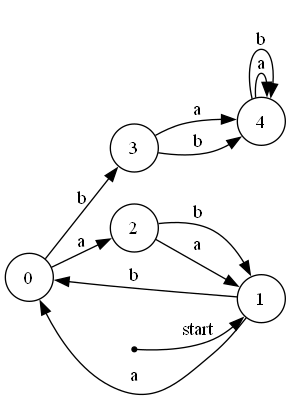


Found 3 SCCs:
  SCC 1: [4]
  SCC 2: [3]
  SCC 3: [0, 1, 2]


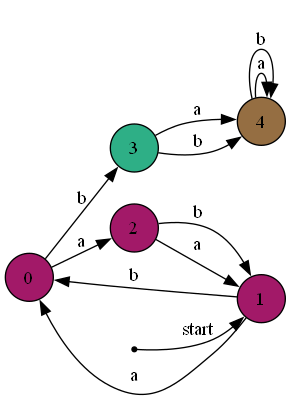

Tarjan's SCC implementation validated successfully.


In [84]:
DFATest.example_4()

In [85]:
@staticmethod
def example_5():
    print("--- Example 5 ---")
    dfa = DFA.empty_dfa()
    dfa.states = [0, 1, 2, 3]
    dfa.n = 4
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        0: {'a': 1, 'b': 1},
        1: {'a': 2, 'b': 2},
        2: {'a': 3, 'b': 3},
        3: {'a': 3, 'b': 3},
    }
    dfa.start_state = 0

    dot = visualize_dfa(dfa, title="Example 5 DFA")
    dot.render('example_5', format='png', cleanup=True)
    display(Image('example_5.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 5")
    dot.render('example_5_scc', format='png', cleanup=True)
    display(Image('example_5_scc.png'))
    DFATest.test_tarjan_properties(dfa)

DFATest.example_5 = example_5


--- Example 5 ---


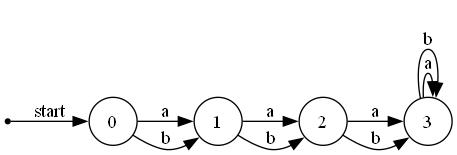


Found 4 SCCs:
  SCC 1: [3]
  SCC 2: [2]
  SCC 3: [1]
  SCC 4: [0]


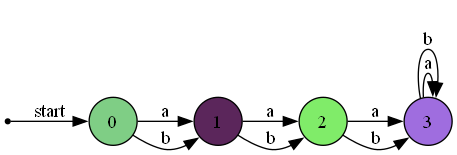

Tarjan's SCC implementation validated successfully.


In [86]:
DFATest.example_5()

In [87]:
@staticmethod
def example_6():
    print("--- Example 6  ---")
    dfa = DFA.empty_dfa()
    dfa.states = [0,1,2,3,4,5,6]
    dfa.n = 7
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        0: {'a': 1, 'b': 1},
        1: {'a': 2, 'b': 3},
        2: {'a': 0, 'b': 4},
        3: {'a': 5, 'b': 5},
        4: {'a': 5, 'b': 5},
        5: {'a': 6, 'b': 6},
        6: {'a': 6, 'b': 6},
    }
    dfa.start_state = 0

    dot = visualize_dfa(dfa, title="Example 6 DFA")
    dot.render('example_6', format='png', cleanup=True)
    display(Image('example_6.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 6")
    dot.render('example_6_scc', format='png', cleanup=True)
    display(Image('example_6_scc.png'))
    DFATest.test_tarjan_properties(dfa)

DFATest.example_6 = example_6


--- Example 6  ---


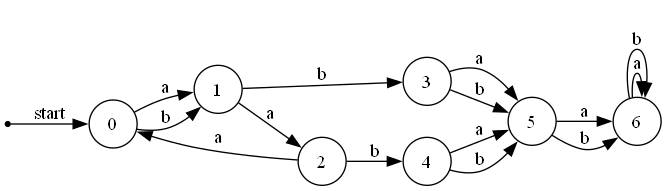


Found 5 SCCs:
  SCC 1: [6]
  SCC 2: [5]
  SCC 3: [4]
  SCC 4: [3]
  SCC 5: [0, 1, 2]


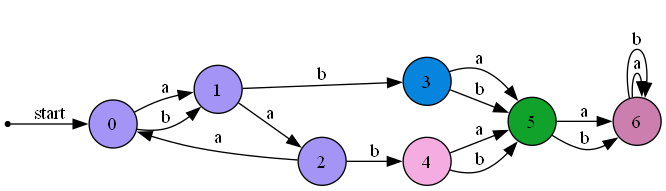

Tarjan's SCC implementation validated successfully.


In [88]:
DFATest.example_6()

In [89]:
@staticmethod
def example_7():
    print("--- Example 7 ---")
    dfa = DFA.empty_dfa()
    dfa.states = list(range(11))
    dfa.n = 11
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        0: {'a': 1, 'b': 3},
        1: {'a': 2, 'b': 4},
        2: {'a': 0, 'b': 6},
        3: {'a': 2, 'b': 2},
        4: {'a': 5, 'b': 6},
        5: {'a': 6, 'b': 7},
        6: {'a': 4, 'b': 4},
        7: {'a': 9, 'b': 9},
        8: {'a': 9, 'b': 9},
        9: {'a': 8, 'b': 8},
        10: {'a': 10, 'b': 10}
    }
    dfa.start_state = 0

    dot = visualize_dfa(dfa, title="Example 7 DFA")
    dot.render('example_7', format='png', cleanup=True)
    display(Image('example_7.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 7")
    dot.render('example_7_scc', format='png', cleanup=True)
    display(Image('example_7_scc.png'))
    DFATest.test_tarjan_properties(dfa)

DFATest.example_7 = example_7

--- Example 7 ---


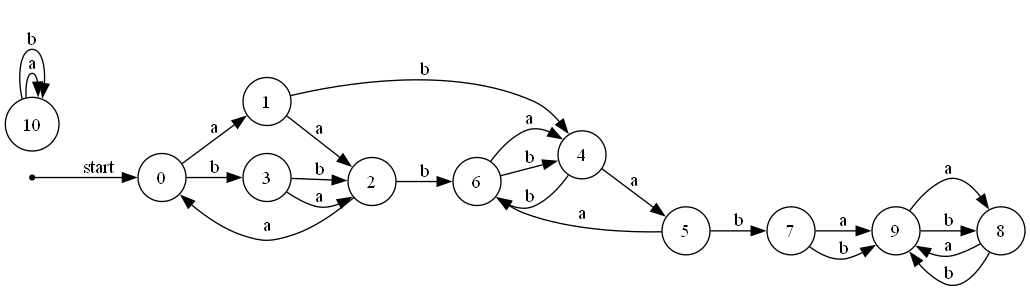


Found 5 SCCs:
  SCC 1: [8, 9]
  SCC 2: [7]
  SCC 3: [4, 5, 6]
  SCC 4: [0, 1, 2, 3]
  SCC 5: [10]


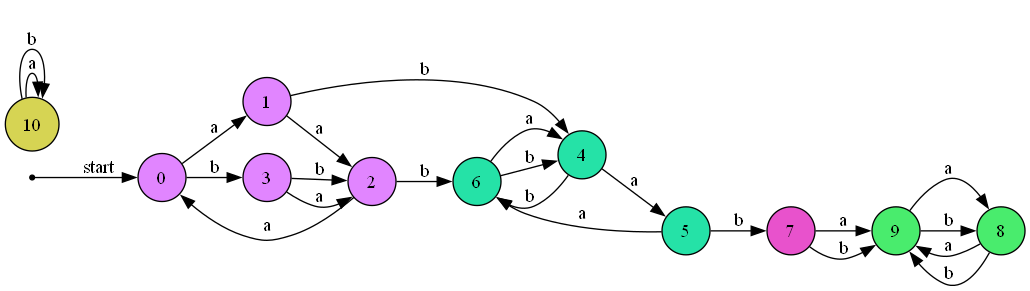

Tarjan's SCC implementation validated successfully.


In [90]:
DFATest.example_7()

In [91]:
@staticmethod
def example_8():
    print("--- Example 8 ---")
    dfa = DFA.empty_dfa()
    dfa.states = list(range(5))
    dfa.n = 5
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        0: {'a': 1, 'b': 1},
        1: {'a': 2, 'b': 2},
        2: {'a': 3, 'b': 4},
        3: {'a': 0, 'b': 0},
        4: {'a': 2, 'b': 2},
    }
    dfa.start_state = 0

    dot = visualize_dfa(dfa, title="Example 8 DFA")
    dot.render('example_8', format='png', cleanup=True)
    display(Image('example_8.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 8")
    dot.render('example_8_scc', format='png', cleanup=True)
    display(Image('example_8_scc.png'))
    DFATest.test_tarjan_properties(dfa)

DFATest.example_8 = example_8

--- Example 8 ---


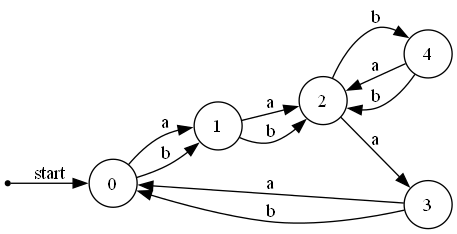


Found 1 SCCs:
  SCC 1: [0, 1, 2, 3, 4]


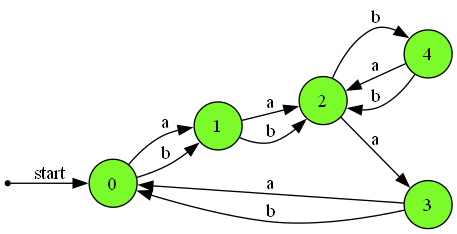

Tarjan's SCC implementation validated successfully.


In [92]:
DFATest.example_8()

In [93]:
@staticmethod
def example_9():
    print("--- Example 9 ---")
    dfa = DFA.empty_dfa()
    dfa.states = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    dfa.n = 9
    dfa.accepting = {s: False for s in dfa.states}

    dfa.transition = {
        1: {'a': 6, 'b': 6},   
        2: {'a': 3, 'b': 3},   
        3: {'a': 4, 'b': 4},  
        4: {'a': 2, 'b': 5},   
        5: {'a': 1, 'b': 9},   
        6: {'a': 5, 'b': 5},  
        7: {'a': 8, 'b': 8},   
        8: {'a': 9, 'b': 9},   
        9: {'a': 7, 'b': 7}
    }

    dfa.start_state = 1

    dot = visualize_dfa(dfa, title="Example 9 DFA")
    dot.render('example_9', format='png', cleanup=True)
    display(Image('example_9.png'))

    sccs = dfa.compute_sccs()
    print_scc(sccs)
    dot = visualize_dfa_scc(dfa, sccs, title="SCCs of Example 9")
    dot.render('example_9_scc', format='png', cleanup=True)
    display(Image('example_9_scc.png'))

    DFATest.test_tarjan_properties(dfa)

DFATest.example_9 = example_9


--- Example 9 ---


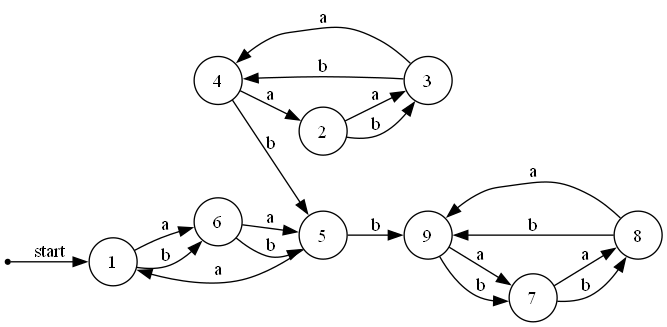


Found 3 SCCs:
  SCC 1: [7, 8, 9]
  SCC 2: [1, 5, 6]
  SCC 3: [2, 3, 4]


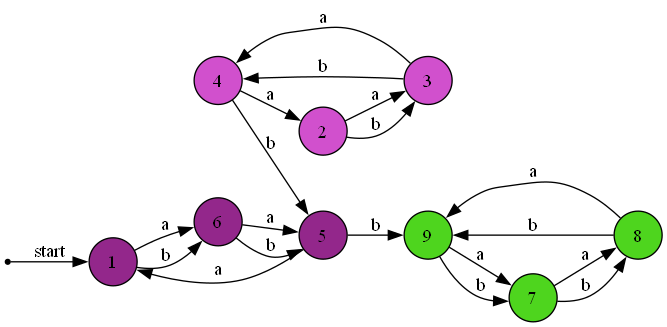

Tarjan's SCC implementation validated successfully.


In [94]:
DFATest.example_9()

In [95]:
@staticmethod
def example_10():
    print("--- Example 10 ---")
    
    dot = visualize_dfa_scc(A, sccs_A, title="SCCs of Example 10 DFA")
    dot.render('example_10', format='png', cleanup=True)
    display(Image('example_10.png'))

    dot = visualize_dfa_scc(M, sccs_M, title="SCCs of Example 10 Minimized")
    dot.render('example_10_minimized_scc', format='png', cleanup=True)
    display(Image('example_10_minimized_scc.png'))

DFATest.example_10 = example_10

--- Example 10 ---


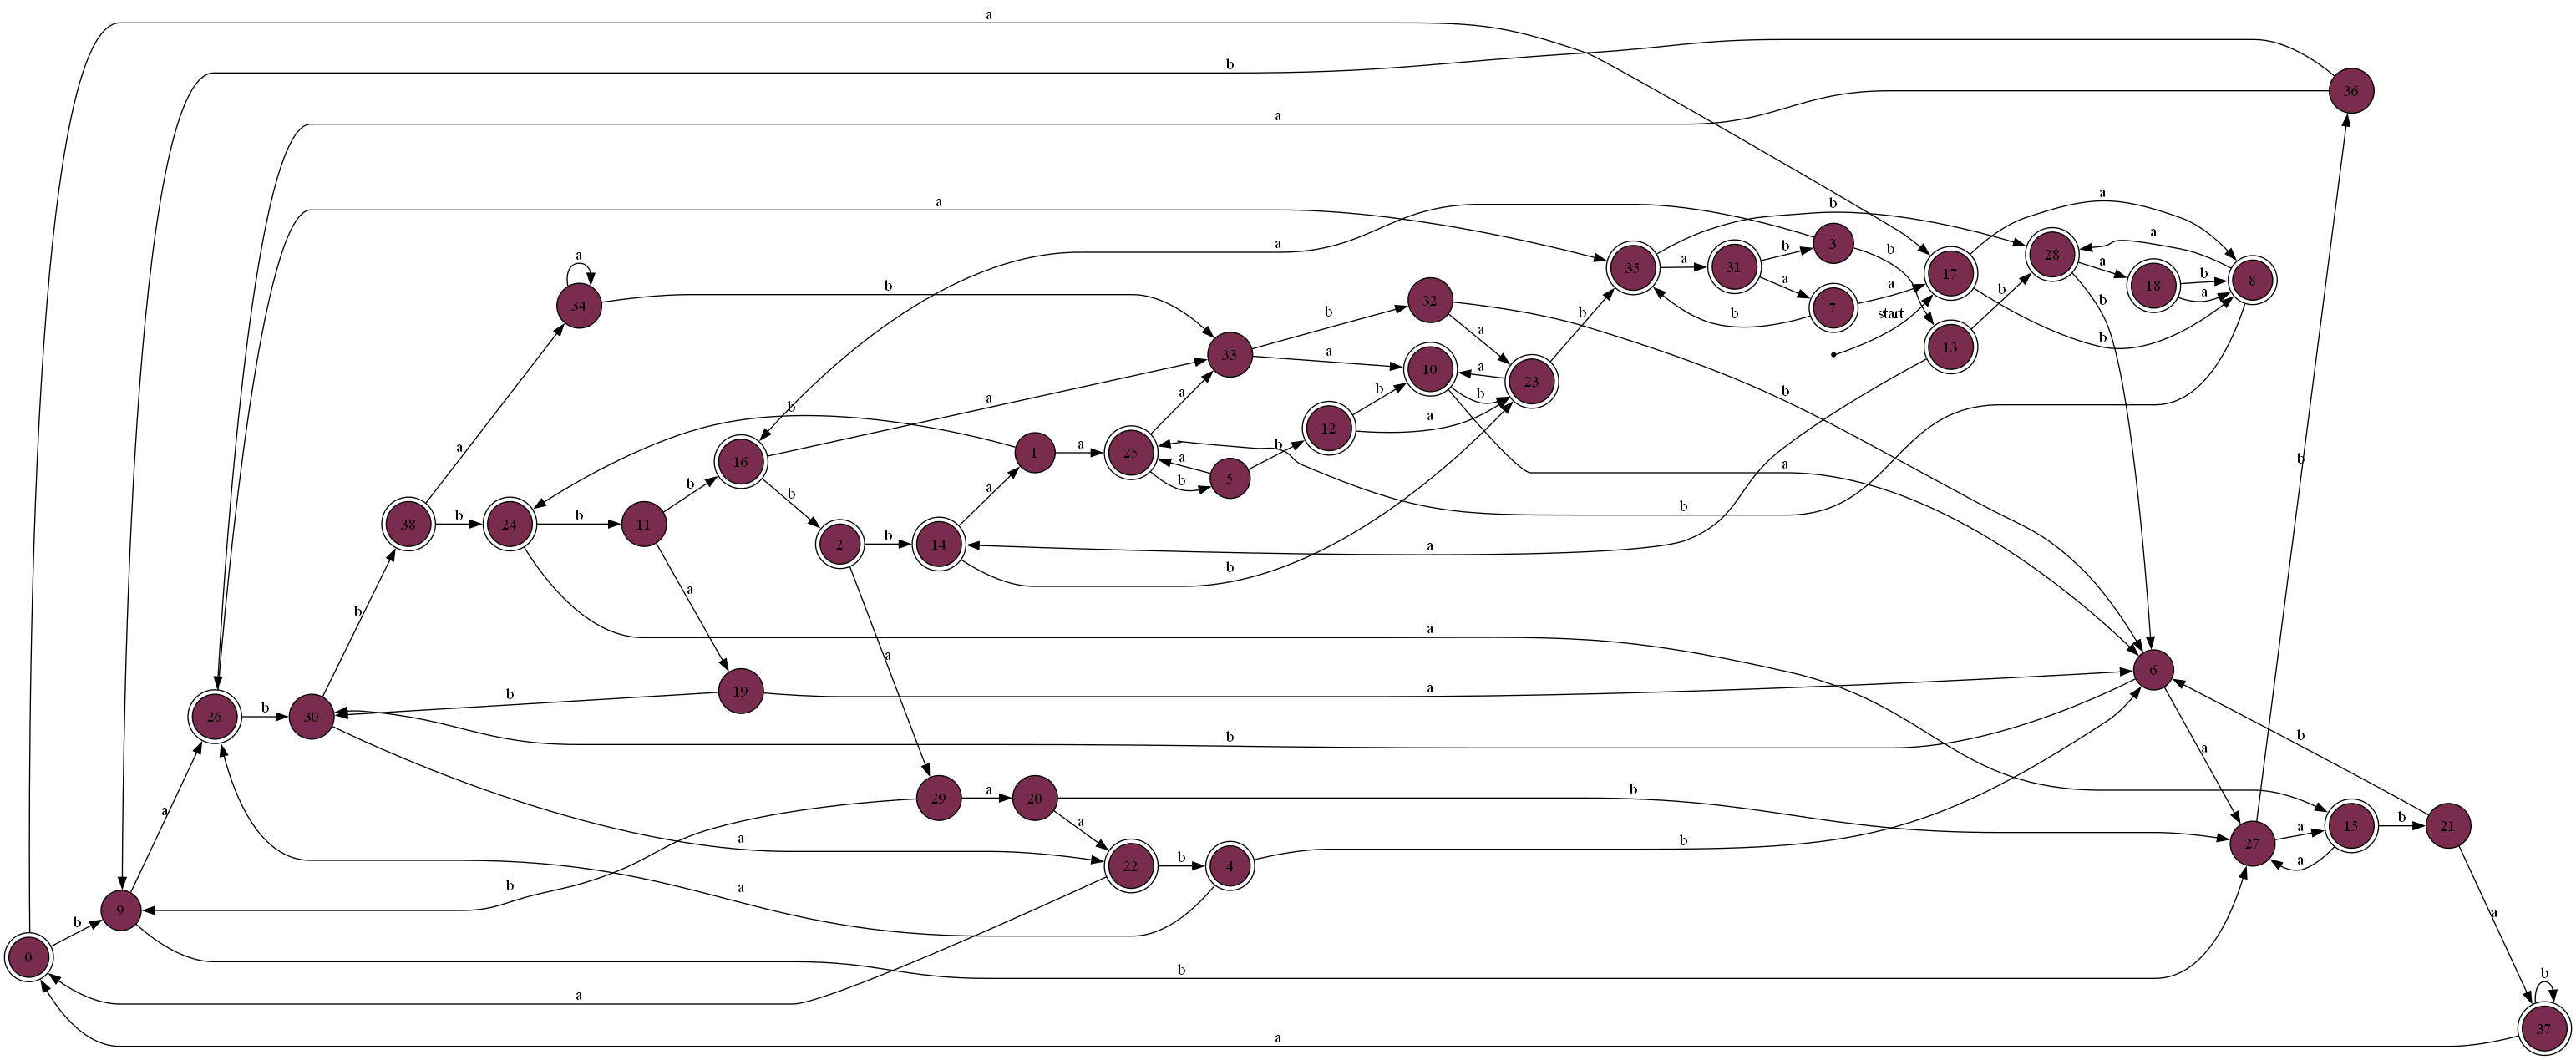

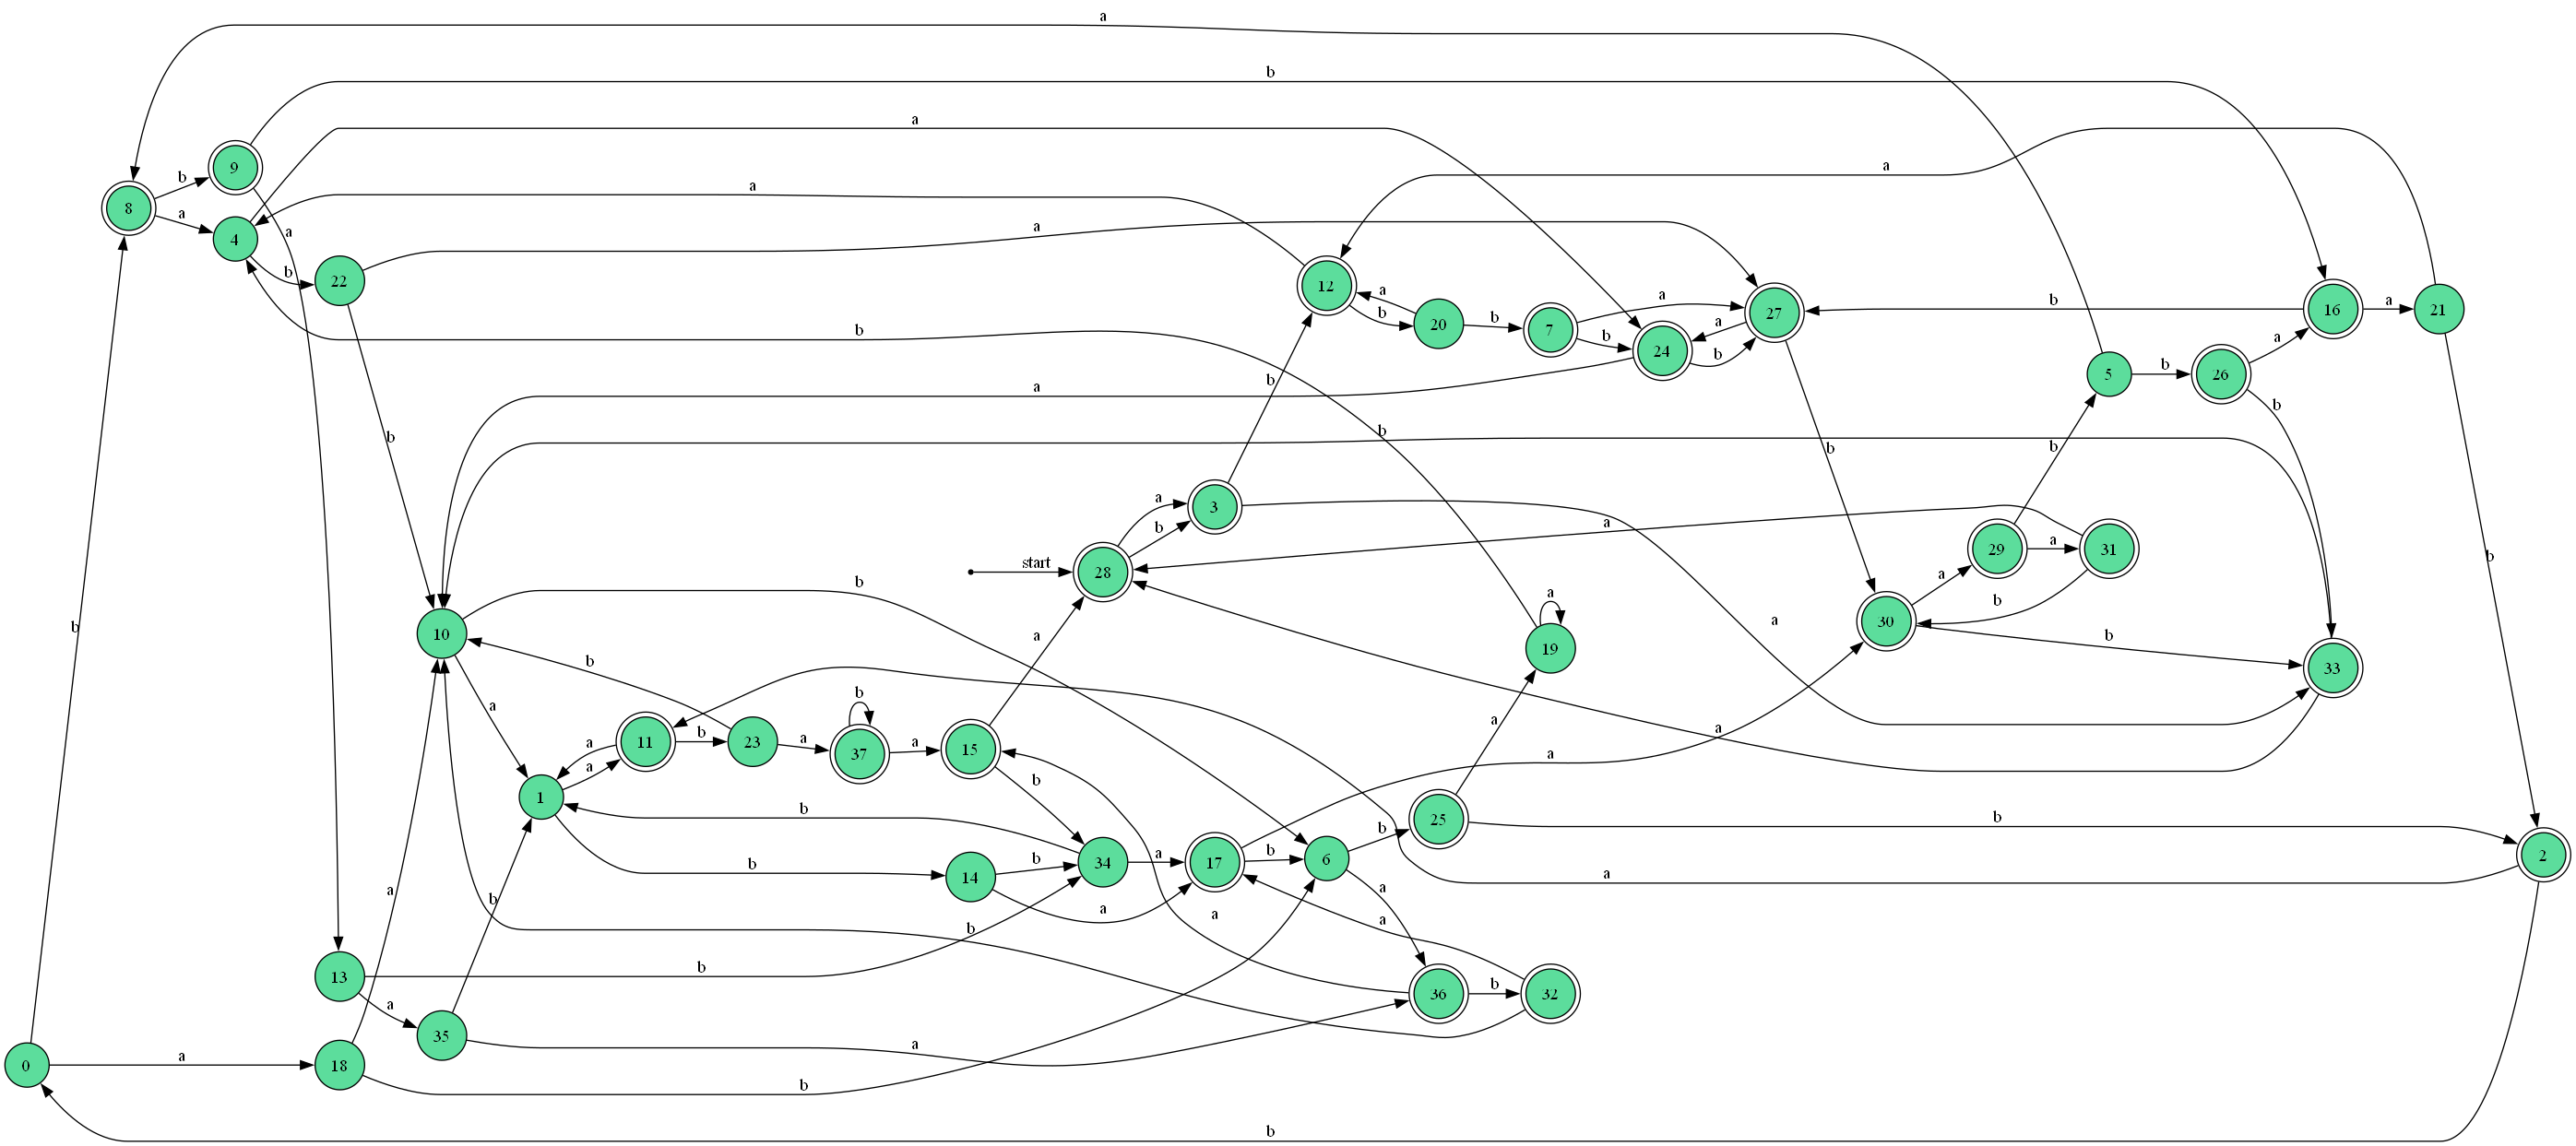

In [96]:
DFATest.example_10()